In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import gc, tqdm, copy

import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler, RobustScaler

from functools import partial
from collections import defaultdict
import pandas as pd
import yaml

2023-09-07 09:40:54.763554: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-07 09:40:57.118252: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /glade/work/schreck/miniconda3/envs/evidential/lib/python3.10/site-packages/nvidia/cudnn/lib:/glade/work/schreck/miniconda3/envs/evidential/lib/python3.10/site-packages/tensorrt_libs:/glade/work/schreck/miniconda3/envs/evidential/lib/:/glade/u/apps/dav/opt/cuda/11.4.0/extras/CUPTI/lib64:/glade/u/apps/dav/opt/cuda/11.4.0/lib64:/glade/u/apps/dav/opt/openmpi/4.1.1/intel/19.1.1/lib:/glade/u/app

### Load a configuation yaml 

In [2]:
config = "../config/surface_layer/mlp.yml"

In [3]:
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

### Load example training data (the full data set is available on Zenodo ... ) 

In [4]:
fn = "../data/sample_cabauw_surface_layer.csv"

In [5]:
input_cols = conf["data"]["input_cols"]
output_cols = ['friction_velocity:surface:m_s-1']

In [6]:
#data[["Time"]+input_cols+output_cols].sample(frac=0.1).to_csv("../data/sample_cabauw_surface_layer.csv")

In [7]:
data_seed = 0
flat_seed = 1000

n_splits = 1
n_models = 1

data = pd.read_csv(fn)
data["day"] = data["Time"].apply(lambda x: str(x).split(" ")[0])

# Need the same test_data for all trained models (data and model ensembles)
flat_seed = 1000
gsp = GroupShuffleSplit(n_splits=1,  random_state = flat_seed, train_size=0.9)
splits = list(gsp.split(data, groups = data["day"]))
train_index, test_index = splits[0]
train_data, test_data = data.iloc[train_index].copy(), data.iloc[test_index].copy() 

# Make N train-valid splits using day as grouping variable
gsp = GroupShuffleSplit(n_splits=n_splits,  random_state = flat_seed, train_size=0.885)
splits = list(gsp.split(train_data, groups = train_data["day"]))
train_index, valid_index = splits[data_seed]
train_data, valid_data = train_data.iloc[train_index].copy(), train_data.iloc[valid_index] .copy()  

In [8]:
x_scaler, y_scaler = RobustScaler(), MinMaxScaler((0, 1))
x_train = x_scaler.fit_transform(train_data[input_cols])
x_valid = x_scaler.transform(valid_data[input_cols])
x_test = x_scaler.transform(test_data[input_cols])

y_train = y_scaler.fit_transform(train_data[output_cols])
y_valid = y_scaler.transform(valid_data[output_cols])
y_test = y_scaler.transform(test_data[output_cols])

### 1. Deterministic multi-layer perceptron (MLP) to predict some quantity

In [9]:
from evml.keras.models import RegressorDNN
from evml.keras.callbacks import get_callbacks

/glade/work/schreck/miniconda3/envs/evidential/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [10]:
conf["model"]["epochs"] = 1
conf["model"]["verbose"] = 1

In [11]:
model = RegressorDNN(**conf["model"])
model.build_neural_network(x_train.shape[-1], y_train.shape[-1])

2023-09-07 09:41:03.628191: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /glade/work/schreck/miniconda3/envs/evidential/lib/python3.10/site-packages/nvidia/cudnn/lib:/glade/work/schreck/miniconda3/envs/evidential/lib/python3.10/site-packages/tensorrt_libs:/glade/work/schreck/miniconda3/envs/evidential/lib/:/glade/u/apps/dav/opt/cuda/11.4.0/extras/CUPTI/lib64:/glade/u/apps/dav/opt/cuda/11.4.0/lib64:/glade/u/apps/dav/opt/openmpi/4.1.1/intel/19.1.1/lib:/glade/u/apps/dav/opt/ucx/1.11.0/lib:/glade/u/apps/opt/intel/2020u1/compilers_and_libraries/linux/lib/intel64
2023-09-07 09:41:03.628242: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://w

In [12]:
model.fit(
    x_train,
    y_train,
    validation_data=(x_valid, y_valid),
    callbacks=get_callbacks(conf, path_extend=f"")
)

20/20 [==============================] - 11s 504ms/step - loss: 1.0176 - mae: 0.4158 - val_loss: 0.0615 - val_mae: 0.1592 - lr: 4.7274e-04


##### Predict with the model

In [13]:
y_pred = y_scaler.inverse_transform(model.predict(x_test))

3/3 [==============================] - 0s 92ms/step


In [14]:
mae = np.mean(np.abs(y_pred[:, 0]-test_data[output_cols[0]]))

In [15]:
mae

0.2221939981274647

### 2. Predict mu and sigma with a "Gaussian MLP"

In [17]:
from evml.keras.models import GaussianRegressorDNN

In [18]:
config = "../config/surface_layer/gaussian.yml"
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)
    
conf["model"]["epochs"] = 1
conf["model"]["verbose"] = 1

In [19]:
gauss_model = GaussianRegressorDNN(**conf["model"])
gauss_model.build_neural_network(x_train.shape[-1], y_train.shape[-1])

In [20]:
gauss_model.fit(
    x_train,
    y_train,
    validation_data=(x_valid, y_valid),
    callbacks=get_callbacks(conf, path_extend=f"")
)

18/18 [==============================] - 1s 24ms/step - loss: 1963.0551 - mae: 0.1657 - val_loss: 0.1397 - val_mae: 0.1094 - lr: 0.0024


In [21]:
y_pred = gauss_model.predict(x_test)

3/3 [==============================] - 0s 3ms/step


In [22]:
# compute variance and std from learned parameters
mu, var = gauss_model.calc_uncertainties(y_pred, y_scaler)

In [23]:
mae = np.mean(np.abs(mu[:, 0]-test_data[output_cols[0]]))
print(mae, np.mean(var) ** (1/2))

0.16284746359490182 0.07228469274888148


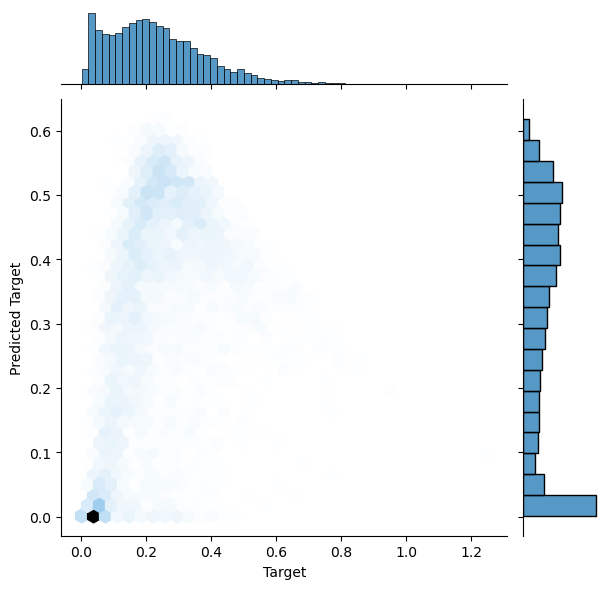

In [24]:
import seaborn as sns
sns.jointplot(x = test_data[output_cols[0]], y = mu[:, 0], kind = 'hex')
plt.xlabel('Target')
plt.ylabel('Predicted Target')
plt.show()

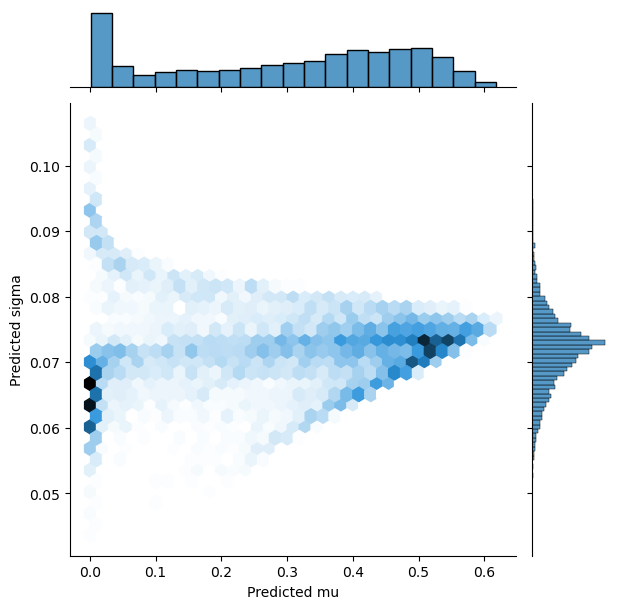

In [25]:
sns.jointplot(x = mu[:, 0], y = np.sqrt(var)[:, 0], kind = 'hex')
plt.xlabel('Predicted mu')
plt.ylabel('Predicted sigma')
plt.show()

### 3. Compute mu, aleatoric, and epistemic quantities using the evidential framework developed by Amini et al. 

In [27]:
from evml.keras.models import EvidentialRegressorDNN

In [28]:
config = "../config/surface_layer/evidential.yml"

In [29]:
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)
    
conf["model"]["epochs"] = 5
conf["model"]["verbose"] = 1

In [30]:
ev_model = EvidentialRegressorDNN(**conf["model"])
ev_model.build_neural_network(x_train.shape[-1], y_train.shape[-1])

In [31]:
ev_model.fit(
    x_train,
    y_train,
    validation_data=(x_valid, y_valid),
    callbacks=get_callbacks(conf, path_extend=f""),
)

Epoch 1/5
12/12 [==============================] - 1s 24ms/step - loss: 11.9275 - mae: 0.1590 - val_loss: 7.3474 - val_mae: 0.1064 - lr: 0.0056
Epoch 2/5
12/12 [==============================] - 0s 11ms/step - loss: 4.8279 - mae: 0.0646 - val_loss: 3.2015 - val_mae: 0.0380 - lr: 0.0056
Epoch 3/5
12/12 [==============================] - 0s 11ms/step - loss: 2.6481 - mae: 0.0286 - val_loss: 2.4255 - val_mae: 0.0270 - lr: 0.0056
Epoch 4/5
12/12 [==============================] - 0s 10ms/step - loss: 2.3017 - mae: 0.0247 - val_loss: 2.6271 - val_mae: 0.0309 - lr: 0.0056
Epoch 5/5
12/12 [==============================] - 0s 11ms/step - loss: 2.3350 - mae: 0.0265 - val_loss: 1.9813 - val_mae: 0.0237 - lr: 0.0056


In [32]:
result = ev_model.predict(x_test, scaler=y_scaler)
mu, aleatoric, epistemic = result

2/2 [==============================] - 0s 2ms/step


In [33]:
mae = np.mean(np.abs(mu[:, 0]-test_data[output_cols[0]]))
print(mae, np.mean(aleatoric) ** (1/2), np.mean(epistemic) ** (1/2))

0.03236658878612571 0.0617233577951793 0.09025916692001004


In [34]:
from evml.regression_uq import compute_results

/glade/work/schreck/miniconda3/envs/evidential/lib/python3.8/site-packages/evml/regression_uq.py:819: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


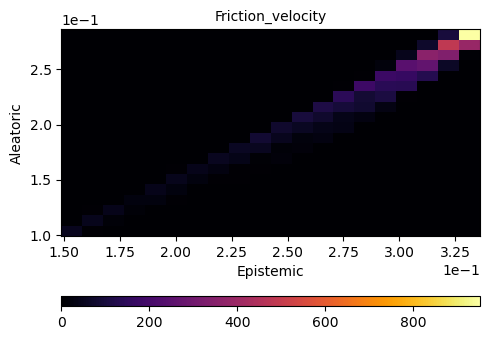

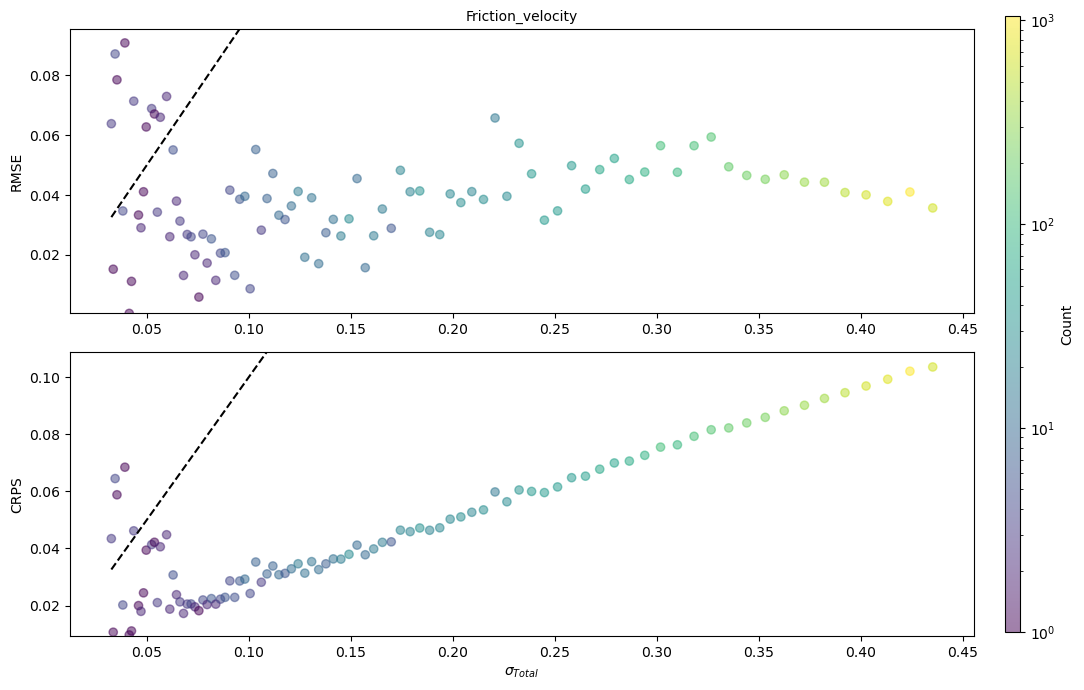

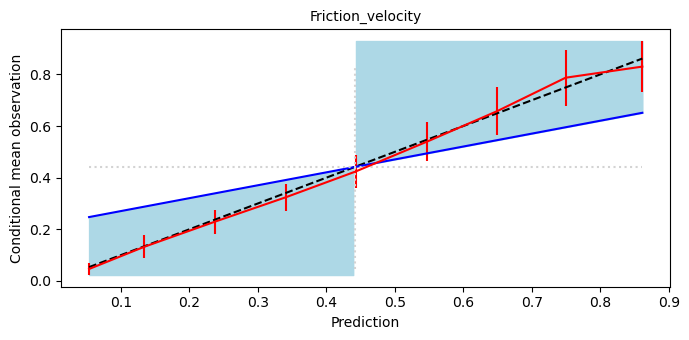

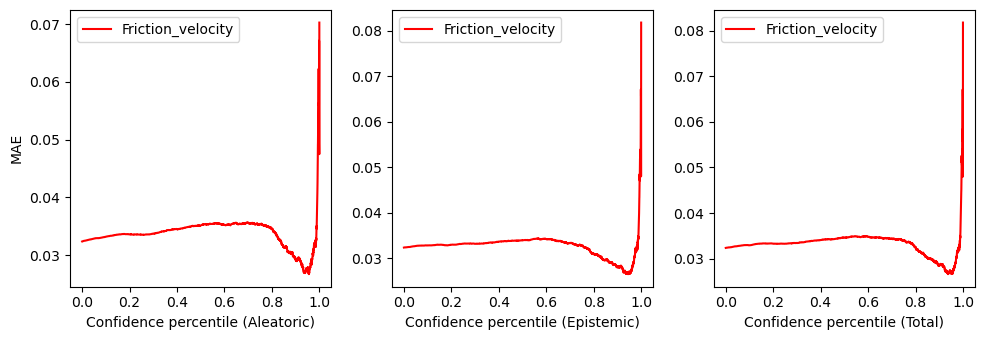

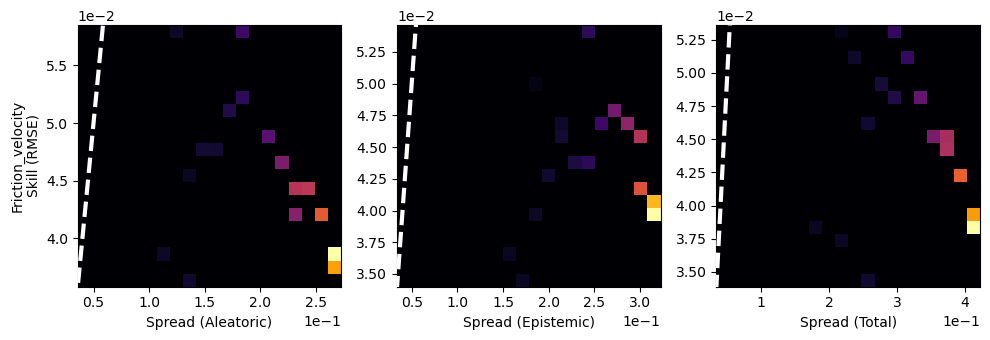

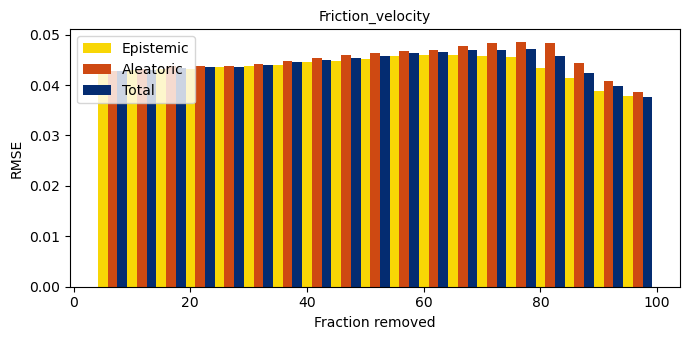

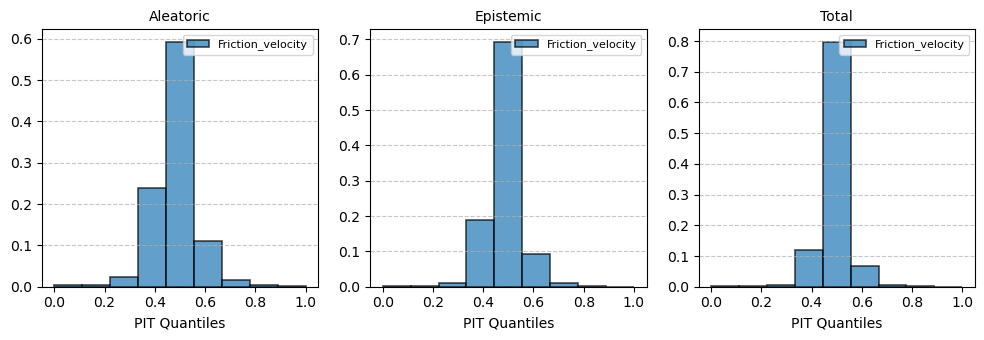

In [35]:
compute_results(test_data, output_cols, mu, np.sqrt(aleatoric), np.sqrt(epistemic))

### 4. Create a deep ensemble with the Gaussian model so that the law of total variance can be applied to compute aleatoric and epistemic

In [36]:
config = "../config/surface_layer/gaussian.yml"
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)
    
conf["model"]["epochs"] = 1
conf["model"]["verbose"] = 1

In [37]:
data_seed = 0
gsp = GroupShuffleSplit(n_splits=1,  random_state = flat_seed, train_size=0.9)
splits = list(gsp.split(data, groups = data["day"]))
train_index, test_index = splits[0]

In [38]:
n_splits = 10
ensemble_mu = np.zeros((n_splits, test_data.shape[0], 1))
ensemble_var = np.zeros((n_splits, test_data.shape[0], 1))

for data_seed in tqdm.tqdm(range(n_splits)):
    data = pd.read_csv(fn)
    data["day"] = data["Time"].apply(lambda x: str(x).split(" ")[0])

    # Need the same test_data for all trained models (data and model ensembles)
    flat_seed = 1000
    gsp = GroupShuffleSplit(n_splits=1,  random_state = flat_seed, train_size=0.9)
    splits = list(gsp.split(data, groups = data["day"]))
    train_index, test_index = splits[0]
    train_data, test_data = data.iloc[train_index].copy(), data.iloc[test_index].copy() 

    # Make N train-valid splits using day as grouping variable
    gsp = GroupShuffleSplit(n_splits=n_splits,  random_state = flat_seed, train_size=0.885)
    splits = list(gsp.split(train_data, groups = train_data["day"]))
    train_index, valid_index = splits[data_seed]
    train_data, valid_data = train_data.iloc[train_index].copy(), train_data.iloc[valid_index] .copy()  

    x_scaler, y_scaler = RobustScaler(), MinMaxScaler((0, 1))
    x_train = x_scaler.fit_transform(train_data[input_cols])
    x_valid = x_scaler.transform(valid_data[input_cols])
    x_test = x_scaler.transform(test_data[input_cols])

    y_train = y_scaler.fit_transform(train_data[output_cols])
    y_valid = y_scaler.transform(valid_data[output_cols])
    y_test = y_scaler.transform(test_data[output_cols])
    
    model = GaussianRegressorDNN(**conf["model"])
    model.build_neural_network(x_train.shape[-1], y_train.shape[-1])
    
    model.fit(
        x_train,
        y_train,
        validation_data=(x_valid, y_valid),
        callbacks=get_callbacks(conf, path_extend=f"")
    )
    
    y_pred = model.predict(x_test)
    mu, var = model.calc_uncertainties(y_pred, y_scaler)
    mae = np.mean(np.abs(mu[:, 0]-test_data[output_cols[0]]))
    
    ensemble_mu[data_seed] = mu
    ensemble_var[data_seed] = var
    
    del model
    tf.keras.backend.clear_session()
    gc.collect()

  0%|          | 0/10 [00:00<?, ?it/s]

3/3 [==============================] - 0s 3ms/step


 10%|█         | 1/10 [00:01<00:16,  1.87s/it]

3/3 [==============================] - 0s 3ms/step


 20%|██        | 2/10 [00:03<00:14,  1.85s/it]

3/3 [==============================] - 0s 3ms/step


 30%|███       | 3/10 [00:05<00:12,  1.83s/it]

3/3 [==============================] - 0s 3ms/step


 40%|████      | 4/10 [00:07<00:10,  1.83s/it]

3/3 [==============================] - 0s 3ms/step


 50%|█████     | 5/10 [00:09<00:09,  1.83s/it]

3/3 [==============================] - 0s 3ms/step


 60%|██████    | 6/10 [00:10<00:07,  1.82s/it]

3/3 [==============================] - 0s 3ms/step


 70%|███████   | 7/10 [00:12<00:05,  1.82s/it]

3/3 [==============================] - 0s 3ms/step


 80%|████████  | 8/10 [00:14<00:03,  1.83s/it]

3/3 [==============================] - 0s 3ms/step


 90%|█████████ | 9/10 [00:16<00:01,  1.82s/it]

3/3 [==============================] - 0s 3ms/step


100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


In [39]:
epistemic = np.var(ensemble_mu, axis=0)
aleatoric = np.mean(ensemble_var, axis=0)

In [40]:
print(epistemic.mean() ** (1/2), aleatoric.mean() ** (1/2))

0.04413089045266657 0.07828741623067934


/glade/work/schreck/miniconda3/envs/evidential/lib/python3.8/site-packages/evml/regression_uq.py:819: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


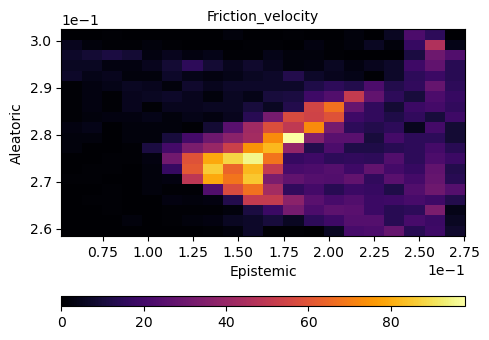

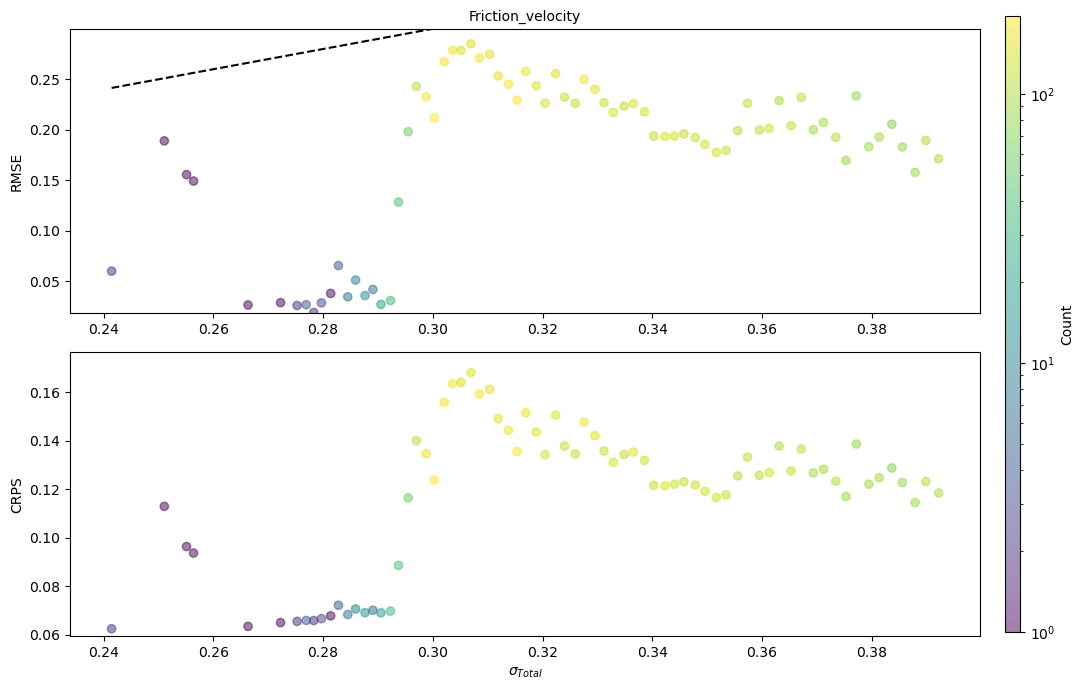

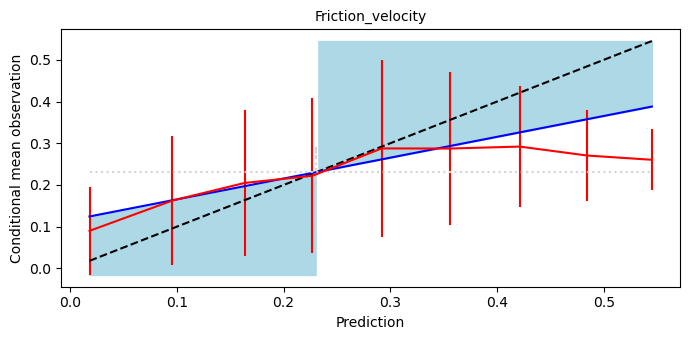

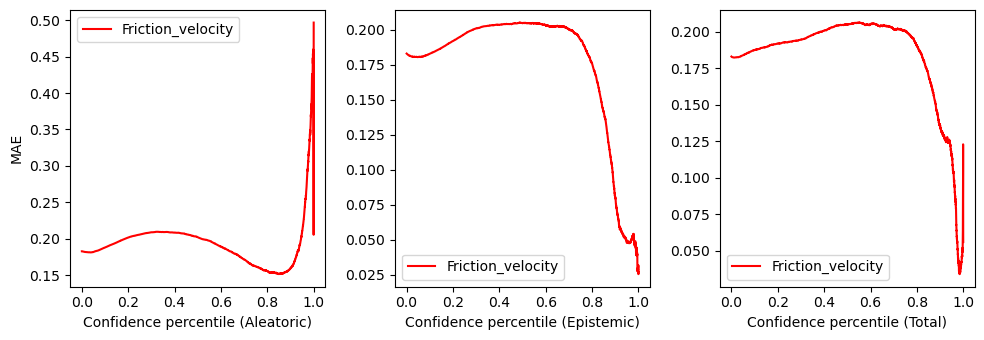

/glade/work/schreck/miniconda3/envs/evidential/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2168: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


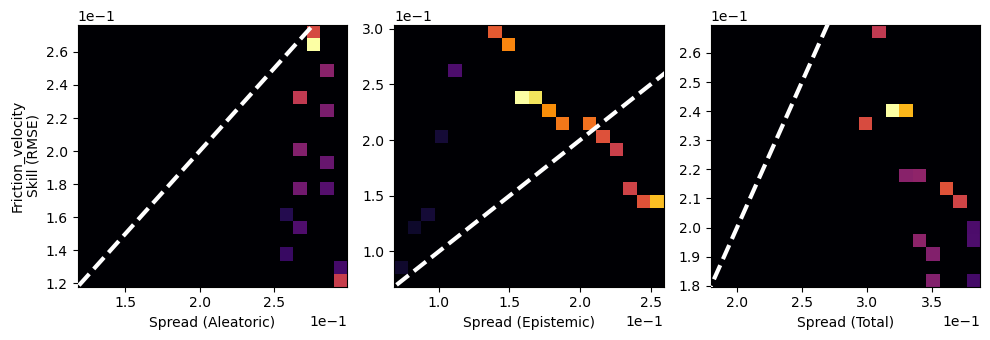

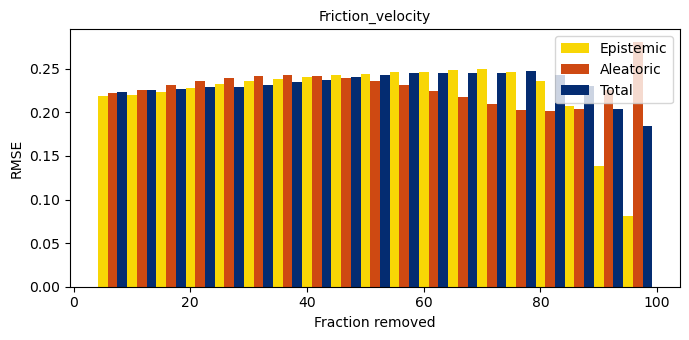

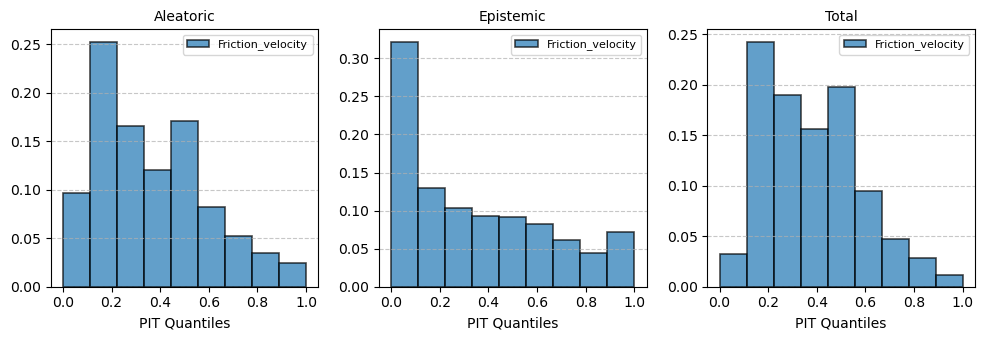

In [41]:
compute_results(test_data, output_cols, np.mean(ensemble_mu, axis=0), np.sqrt(aleatoric), np.sqrt(epistemic))